In [1]:
import json
import itertools
import scipy
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import *
from collections import defaultdict
from utils import get_session_ids, get_all_sequences, get_topics, get_sub_topics, RegExp, product,to_matrix
from search_engine import *
from numpy.random import choice
from tqdm.notebook import tqdm
from multiprocessing import Pool

np.set_printoptions(precision=3)

# Data Preprocessing

In [2]:
path_log = './data/log.2.tsv'
path_topic = './data/topic.tsv'
path_sub_topic = './data/sub_topic.tsv'
path_retrievable_paragraph = './data/retrievable_paragraph.tsv'

In [3]:
session_ids = get_session_ids(path_log)
all_sequences = get_all_sequences(path_log, session_ids)

In [4]:
topics = get_topics(path_topic)

topics

{1: 'harvard university',
 2: 'black death',
 3: 'intergovernmental panel on climate change',
 4: 'private schools',
 5: 'geology',
 6: 'economic inequality',
 7: 'immune system',
 8: 'oxygen',
 9: 'normans',
 10: 'amazon rainforest',
 11: 'european union law'}

In [5]:
# topic -> sub_topic -> queries
all_queries = {}

for topic in all_sequences:
    
    queries = defaultdict(list)
    for sequence in all_sequences[topic]:
        for action in sequence:
            sub_topic = action[3]
            query = action[4]
            queries[sub_topic].append(query)
    
    all_queries[topic] = queries

all_queries

{8: defaultdict(list,
             {44: ['oxygen',
               'how is oxygen used in the body',
               "oxygen's role in humans",
               'what is the main use of oxygen',
               'oxygen biological role',
               'oxygen biological role',
               'oxygen',
               'oxygen',
               'biological role of oxygen',
               'periodic table element oxygen',
               'facts and characteristics of oxygen',
               'role of oxygen on earth',
               'biological role of oxygen',
               'importance of oxygen in biology',
               'oxygen',
               'biological role of oxygen',
               'what is the biological role of oxygen',
               'oxygen and organisms',
               'oxygen medical',
               'oxygen',
               'oxygen biology',
               'oxygen',
               'biological role of oxygen'],
              43: ['facts and characteristics of oxygen',
            

In [6]:
# topic -> sub_topic -> paragraphs
qrels = defaultdict(dict)

sub_topic_to_paragraph = defaultdict(set)
with open(path_retrievable_paragraph) as f:
    for line in f.readlines()[1:]:
        items = line.split('\t')
        sub_topic = int(items[0])
        paragraph = int(items[1])
        sub_topic_to_paragraph[sub_topic].add(paragraph)

sub_topics = get_sub_topics(path_sub_topic)

for topic in sub_topics:
    for sub_topic in sub_topics[topic]:
        qrels[topic][sub_topic] = sub_topic_to_paragraph[sub_topic]

qrels

defaultdict(dict,
            {10: {1: {372, 374},
              2: {371},
              3: {379, 380, 381},
              4: {385, 386},
              5: {371}},
             5: {6: {496},
              7: {498, 499, 521},
              8: {501},
              9: {502, 503, 504, 521},
              10: {505, 511},
              11: {499, 521}},
             6: {12: {689, 699},
              13: {675, 676, 689},
              14: {675, 689, 699},
              15: {689, 699, 708, 713},
              16: {674, 675, 676},
              17: {675, 708}},
             4: {18: {607},
              19: {597},
              20: {597},
              21: {596},
              22: {596, 600},
              23: {599, 607},
              24: {600},
              25: {596, 619},
              26: {602},
              27: {602, 619}},
             2: {28: {474, 475, 480},
              29: {474, 475, 476, 477, 491},
              30: {483},
              31: {474, 475, 491, 495},
              32: {47

In [7]:
# from users continuos
# topic -> sub_topic -> paragraphs
qrels_users = {}

for topic in sub_topics:
    for sequence in all_sequences[topic]:
        for action in sequence:
            paragraph = action[1]
            rel = action[2]
            sub_topic = action[3]
            if topic not in qrels_users:
                qrels_users[topic] = {}
            if sub_topic not in qrels_users[topic]:
                qrels_users[topic][sub_topic] = {}
            if paragraph not in qrels_users[topic][sub_topic]:
                qrels_users[topic][sub_topic][paragraph] = (0, 0)
            num, den = qrels_users[topic][sub_topic][paragraph]
            if rel == 'relevant':
                qrels_users[topic][sub_topic][paragraph] = (num + 1, den + 1)
            else:
                qrels_users[topic][sub_topic][paragraph] = (num, den + 1)

for topic in qrels_users:
    for sub_topic in qrels_users[topic]:
        for paragraph in qrels_users[topic][sub_topic]:
            num, den = qrels_users[topic][sub_topic][paragraph]
            qrels_users[topic][sub_topic][paragraph] = num/den
            
qrels_users

{10: {1: {374: 0.8333333333333334, 372: 1.0},
  2: {371: 0.95},
  3: {380: 0.7222222222222222, 381: 0.7, 379: 1.0},
  4: {386: 0.6551724137931034, 385: 1.0},
  5: {371: 0.5714285714285714}},
 5: {9: {521: 0.8235294117647058, 504: 0.6666666666666666, 502: 1.0},
  7: {499: 0.3333333333333333, 521: 0.42105263157894735},
  8: {501: 0.8},
  6: {496: 0.03125},
  11: {521: 0.6666666666666666, 499: 0.26666666666666666},
  10: {511: 0.9444444444444444}},
 6: {13: {675: 0.8, 689: 1.0},
  15: {699: 0.75, 708: 1.0},
  12: {689: 1.0, 699: 0.5},
  16: {675: 0.9230769230769231, 674: 1.0},
  17: {708: 1.0, 675: 0.4},
  14: {675: 0.42857142857142855, 699: 1.0}},
 4: {22: {600: 0.6538461538461539},
  25: {619: 1.0, 596: 1.0},
  21: {596: 1.0},
  26: {602: 0.26666666666666666},
  20: {597: 0.5882352941176471},
  18: {607: 0.8421052631578947},
  19: {597: 0.2631578947368421},
  27: {602: 1.0},
  23: {607: 1.0},
  24: {600: 0.0}},
 2: {32: {487: 0.9259259259259259, 480: 1.0, 475: 0.0},
  28: {474: 0.958333

# Setup Search System

In [8]:
direct_index = DirectIndex.load()

In [9]:
pre_preocessor = PreProcessor()

def select_random_documents(documents:set, p:float=0.0):
    assert(0.0 <= p <= 1.0)
    if p == 0.0:
        return set()
    elif p == 1.0:
        return documents
    else:
        return set(choice(list(documents), replace=False, size = int(len(documents) * p)))
        
def get_search_engine(topic, sub_topic, qrels, direct_index, noise = 0.0):
    # select documents belonging to the topic
    selected_documents = {}
    for document in qrels[topic][sub_topic]:
        selected_documents[document] = direct_index.index[document]
        
    # select random documents
    # 1. from topic documents
    topic_documents = set()
    for _, sub_topic_documents in qrels[topic].items():
        topic_documents.update(sub_topic_documents)    
    topic_documents = select_random_documents(topic_documents, noise)
    
    for document in topic_documents:
        selected_documents[document] = direct_index.index[document]
    
    # 2. from all_documents
    all_documents = direct_index.index.keys()
    all_documents = select_random_documents(all_documents, noise)

    for document in all_documents:
        selected_documents[document] = direct_index.index[document]
        
    # retrievable documents
    inverted_index = InvertedIndex()
    inverted_index.create(selected_documents)
        
    return selected_documents, inverted_index

# stats
inverted_index = InvertedIndex()
inverted_index.create(direct_index.index)

# test
for topic in sub_topics:
    for sub_topic in sub_topics[topic]:
        print(topic, topics[topic], sub_topic)
        r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index, 0.01)
        print("over", len(r_documents), "documents")
        r_inverted_index.cl = inverted_index.cl
        r_inverted_index.dictionary = inverted_index.dictionary
        search = Search(r_inverted_index, r_documents, pre_preocessor)
        print(search.search('amazon', n=2, retrievable_paragraphs=r_documents.keys()))
    break

10 amazon rainforest 1
over 204 documents
[374, 384]
10 amazon rainforest 2
over 203 documents
[371, 373]
10 amazon rainforest 3
over 205 documents
[381, 379]
10 amazon rainforest 4
over 204 documents
[386, 14076]
10 amazon rainforest 5
over 203 documents
[371, 29]


# Simulations

In [10]:
num_samples = 100000

In [11]:
def generate_sequence(num_subtopics, min_sub_topics = 1):
    prob = 1.0
    sequence = []
    current_subtopic = 0
    
    next_subtopic = choice(range(1, num_subtopics + 1), 1)[0]
    prob *= 1.0/num_subtopics
    sequence.append((current_subtopic, None, None, next_subtopic + min_sub_topics - 1, None))
    current_subtopic = next_subtopic
    
    while next_subtopic + min_sub_topics - 1 != num_subtopics + 1 + min_sub_topics - 1:
        next_subtopic = choice(range(1, num_subtopics + 2), 1)[0]
        prob *= 1.0/(num_subtopics + 1)
        sequence.append((current_subtopic + min_sub_topics - 1, 
                         None, None, 
                         next_subtopic + min_sub_topics - 1, None))
        current_subtopic = next_subtopic
        
    return sequence, prob

sequence, prob = generate_sequence(5)

print(sequence)

[(0, None, None, 3, None), (3, None, None, 1, None), (1, None, None, 1, None), (1, None, None, 6, None)]


In [12]:
def get_transitions_table(num_subtopics, min_sub_topic, sequences, epsilon = 0.0):
    transitions_table = defaultdict(float)
    for sequence in sequences:
        last_key = None
        for n, action in enumerate(sequence):
            if n == 0:
                key = (action[0], action[3] - min_sub_topic + 1)
            else:
                key = (action[0] - min_sub_topic + 1, action[3] - min_sub_topic + 1)
            transitions_table[key] += 1
            last_key = key
        transitions_table[(last_key[1], num_subtopics+1)] += 1
    
    norms = defaultdict(float)
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if not (from_subtopic == 0 and to_subtopic == num_subtopics + 1):            
            transitions_table[(from_subtopic, to_subtopic)] += epsilon
        norms[from_subtopic] += transitions_table[(from_subtopic, to_subtopic)]
    
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if norms[from_subtopic] > 0.0:
            transitions_table[(from_subtopic, to_subtopic)] /= norms[from_subtopic]
            
    return transitions_table

def generate_sequence_from_table(num_subtopics, min_sub_topics, table):
    prob = 1.0
    table = to_matrix(table)
    sequence = []
    current_subtopic = 0
    
    next_subtopic = choice(range(1, num_subtopics + 2), 1, p=table[0])[0]
    prob *= table[0, next_subtopic - 1]
    sequence.append((current_subtopic, None, None, next_subtopic + min_sub_topics - 1, None))
    current_subtopic = next_subtopic
    
    while next_subtopic + min_sub_topics - 1 != num_subtopics + 1 + min_sub_topics - 1:
        next_subtopic = choice(range(1, num_subtopics + 2), 1, p=table[current_subtopic])[0]
        prob *= table[current_subtopic, next_subtopic-1]
        sequence.append((current_subtopic + min_sub_topics - 1, 
                         None, None, 
                         next_subtopic + min_sub_topics - 1, None))
        current_subtopic = next_subtopic
    
    return sequence, prob

In [13]:
def get_transitions_tables(num_subtopics, min_sub_topic, sequences, epsilon = 0.0):
    rel_transitions_table = defaultdict(float)
    irr_transitions_table = defaultdict(float)
    p_rel = defaultdict(float)
    p_irr = defaultdict(float)
    for sequence in sequences:
        last_key = None
        last_rel = 'irrelevant'
        for n, action in enumerate(sequence):
            if n == 0:
                key = (action[0], action[3] - min_sub_topic + 1)
            else:
                key = (action[0] - min_sub_topic + 1, action[3] - min_sub_topic + 1)
            if last_rel == 'relevant':
                rel_transitions_table[key] += 1
                p_rel[key[0]] += 1
            else:
                irr_transitions_table[key] += 1
                p_irr[key[0]] += 1
            last_key = key
            last_rel = action[2]
        
        if last_rel == 'relevant':
            rel_transitions_table[(last_key[1], num_subtopics+1)] += 1
            p_rel[last_key[1]] += 1
        else:
            irr_transitions_table[(last_key[1], num_subtopics+1)] += 1
            p_irr[last_key[1]] += 1
        
    rel_norms = defaultdict(float)
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if from_subtopic > 0:            
            rel_transitions_table[(from_subtopic, to_subtopic)] += epsilon
        rel_norms[from_subtopic] += rel_transitions_table[(from_subtopic, to_subtopic)]
    
    irr_norms = defaultdict(float)
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if not (from_subtopic == 0 and to_subtopic == num_subtopics + 1):
            irr_transitions_table[(from_subtopic, to_subtopic)] += epsilon
        irr_norms[from_subtopic] += irr_transitions_table[(from_subtopic, to_subtopic)]
    
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if rel_norms[from_subtopic] > 0.0:
            rel_transitions_table[(from_subtopic, to_subtopic)] /= (rel_norms[from_subtopic]) 
    
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if irr_norms[from_subtopic] > 0.0:
            irr_transitions_table[(from_subtopic, to_subtopic)] /= (irr_norms[from_subtopic])
    
    p = []
    for t in range(num_subtopics + 1):
        if (p_rel[t] + p_irr[t]) > 0:
            p.append(p_rel[t]/(p_rel[t] + p_irr[t]))
        else:
            p.append(0.0)
    p = np.array([p])

    return rel_transitions_table, irr_transitions_table, p, 1 - p

In [14]:
class SequenceGenerator:
    
    def __init__(self, num_subtopics, min_sub_topic, rel_table, irr_table):
        self.num_subtopics = num_subtopics
        self.rel_table = to_matrix(rel_table)
        self.irr_table = to_matrix(irr_table)
        self.min_sub_topic = min_sub_topic
        self.relevance = False
        self.current_subtopic = 0
        
    def __iter__(self):
        #self.current_subtopic = 0
        return self
    
    def set_relevance(self, relevance):
        self.relevance = relevance
    
    def __next__(self):
        next_subtopic = -1
        prob = -1
        if self.current_subtopic + self.min_sub_topic - 1 == self.num_subtopics + 1 + self.min_sub_topic - 1:
            raise StopIteration
        if self.relevance:
            #print(self.rel_table[self.current_subtopic].sum())
            next_subtopic = choice(range(1, self.num_subtopics + 2), 
                                   1, 
                                   p=self.rel_table[self.current_subtopic])[0]
            prob = self.rel_table[self.current_subtopic, next_subtopic - 1]
        else:
            #print(self.irr_table[self.current_subtopic].sum())
            next_subtopic = choice(range(1, self.num_subtopics + 2), 
                                   1, 
                                   p=self.irr_table[self.current_subtopic])[0]
            prob = self.irr_table[self.current_subtopic, next_subtopic - 1]
        self.current_subtopic = next_subtopic
        return next_subtopic + self.min_sub_topic - 1, prob

# Correlation Analysis with Satisfaction

In [15]:
# CP

def dd_cp(alpha, m, l):
    return 1

def ncp(sequence):
    res = 0.0
    for action in sequence:
        if action[2] == 'relevant':
            res += dd_cp(None, None, None)
    return res/len(sequence)

def get_ncp_list(sequences):
    res = []
    for sequence, _ in sequences:
        res.append(ncp(sequence))
    return res

# CBP

def dd_cbp(alpha, m, l = None):
    return alpha ** m

def dd_ncbp(alpha, m, l):
    return dd_cbp(alpha, m, l)

def ncbp(sequence, alpha):
    norm = 0.0
    for i in range(len(sequence)):
        norm += dd_cbp(alpha, i, len(sequence))
    res = 0.0
    for m, action in enumerate(sequence):
        if action[2] == 'relevant':
            res += dd_ncbp(alpha, m, len(sequence))
    return res/norm

def get_ncbp_list(sequences, alpha):
    res = []
    for sequence, _ in sequences:
        res.append(ncbp(sequence, alpha))
    return res

# ECS

def dd_necs(alpha_rel, alpha_irr, m, sequence):
    res = 1.0
    for action in sequence[:m]:
        if action[2] == 'relevant':
            res *= alpha_rel
        else:
            res *= alpha_irr
    return res

def necs(sequence, alpha_rel, alpha_irr):
    norm = 0.0
    for i in range(len(sequence)):
        norm += dd_cbp(alpha_rel, i)
    res = 0.0
    for m, action in enumerate(sequence):
        if action[2] == 'relevant':
            res += dd_necs(alpha_rel, alpha_irr, m, sequence)
    return res/norm

def get_necs_list(sequences, alpha_rel, alpha_irr):
    res = []
    for sequence, prob in sequences:
        res.append(necs(sequence, alpha_rel, alpha_irr))
    return res

# Noise Analysis

In [16]:
num_samples = 10000
res = 10

In [17]:
def get_scores_with_noise(noise):
    noise = noise/res

    topic_scores_necs = []
    topic_scores_ncbp = []
    topic_scores_ncp = []
    for topic in topics:
        num_subtopics = len(sub_topics[topic])

        all_r_documents = {}
        all_r_inverted_index = {}
        for sub_topic in sub_topics[topic]:
            r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index, noise)
            all_r_documents[sub_topic] = r_documents
            all_r_inverted_index[sub_topic] = r_inverted_index

        rel_table, irr_table, p_rel, _ = get_transitions_tables(num_subtopics, 
                                                                min(sub_topics[topic]), 
                                                                all_sequences[topic], 
                                                                10e-6)
        scores_necs = []
        scores_ncbp = []
        scores_ncp = []
        for _ in range(num_samples):
            sg = SequenceGenerator(num_subtopics, min(sub_topics[topic]), rel_table, irr_table)
            prob = 1.0
            prev_sub_topic = 0
            sequence = []
            for m, (sub_topic, prob_action) in enumerate(sg):

                if sub_topic != num_subtopics + 1 + min(sub_topics[topic]) - 1:
                    query = ''
                    if sub_topic in all_queries[topic] and len(all_queries[topic][sub_topic]) > 0: 
                        queries = all_queries[topic][sub_topic]
                        query = queries[choice(range(len(queries)))]

                    search.set_indices(all_r_inverted_index[sub_topic], all_r_documents[sub_topic])
                    answer = search.search(query, 
                                           n=1, 
                                           retrievable_paragraphs=all_r_documents[sub_topic].keys())[0]

                    if sub_topic in qrels_users[topic] and answer in qrels_users[topic][sub_topic] and \
                    np.random.uniform(0,1) < qrels_users[topic][sub_topic][answer]:
                        sg.set_relevance(True)
                        sequence.append((prev_sub_topic, answer, 'relevant', sub_topic, query))
                    else:
                        sg.set_relevance(False)
                        sequence.append((prev_sub_topic, answer, 'irrelevant', sub_topic, query))
                
                prev_sub_topic = sub_topic
                prob *= prob_action

            scores_necs.append(necs(sequence, 0.85, 0.64))
            scores_ncbp.append(ncbp(sequence, 0.79))
            scores_ncp.append(ncp(sequence))

        scores_necs = np.array(scores_necs)
        topic_score_necs = np.mean(scores_necs)
        topic_scores_necs.append((topic, topic_score_necs))
        
        scores_ncbp = np.array(scores_ncbp)
        topic_score_ncbp = np.mean(scores_ncbp)
        topic_scores_ncbp.append((topic, topic_score_ncbp))
        
        scores_ncp = np.array(scores_ncp)
        topic_score_ncp = np.mean(scores_ncp)
        topic_scores_ncp.append((topic, topic_score_ncp))

    return noise, topic_scores_necs, topic_scores_ncbp, topic_scores_ncp


In [18]:
def get_all_evaluation_measures(pool_res):
    ys_ncp = []
    ys_ncbp = []
    ys_necs = []
    for noise, topic_scores_necs, topic_scores_ncbp, topic_scores_ncp in pool_res:
        ys_necs.append(np.mean([tv[1] for tv in topic_scores_necs]))
        ys_ncbp.append(np.mean([tv[1] for tv in topic_scores_ncbp]))
        ys_ncp.append(np.mean([tv[1] for tv in topic_scores_ncp]))
        
    return {'necs': ys_necs, 'ncbp': ys_ncbp, 'ncp': ys_ncp}

## TF-IDF

In [19]:
search = Search(None, {}, pre_preocessor, scorer=TFIDF())

noises = list(range(0, res+1))
pool = Pool(32)
pool_res = list(tqdm(pool.imap_unordered(get_scores_with_noise, noises, chunksize=1), total=len(noises)))
pool.terminate()

tfidf_pool_res = pool_res
get_all_evaluation_measures(pool_res)

{'necs': [0.6480172462537686,
  0.31871854586654885,
  0.27717513482575035,
  0.19569333726999505,
  0.1604677337375594,
  0.14134818035363683,
  0.13932507624853951,
  0.12339797193743847,
  0.13062152889338888,
  0.12886620032282495,
  0.12774328267323443],
 'ncbp': [0.7094521638961644,
  0.37649594182975954,
  0.32011672435681604,
  0.22990267738096135,
  0.19216998982741398,
  0.16979411085080878,
  0.16673761517444874,
  0.1464459212398968,
  0.1549610692813181,
  0.1526122256702885,
  0.15187601292853894],
 'ncp': [0.6947958096130041,
  0.368349659233272,
  0.3016578849923671,
  0.21811541596475478,
  0.18409352412506982,
  0.16183500433268594,
  0.158088588240211,
  0.13802234302209512,
  0.14686920422087993,
  0.14445257814014048,
  0.14298755798203275]}

## D-LM

In [20]:
max_necs = 0
max_pool_res = None

for mu in tqdm(range(10 + 1)):
    mu = (mu + 1) * 10
    
    search = Search(None, {}, pre_preocessor, scorer=DirichletSmoothingLM(mu))
    
    noises = list(range(0, res+1))
    pool = Pool(32)
    pool_res = list(pool.imap_unordered(get_scores_with_noise, noises, chunksize=1))
    pool.terminate()
    
    cur_necs = max(get_all_evaluation_measures(pool_res)['necs'])
    if max_necs < cur_necs:
        max_necs = cur_necs
        max_mu = mu
        max_pool_res = pool_res

d_lm_pool_res = max_pool_res
d_lm_mu = max_mu
get_all_evaluation_measures(max_pool_res)

Process ForkPoolWorker-165:
Process ForkPoolWorker-167:
Process ForkPoolWorker-169:
Process ForkPoolWorker-163:
Process ForkPoolWorker-170:
Process ForkPoolWorker-171:
Process ForkPoolWorker-162:
Process ForkPoolWorker-164:
Process ForkPoolWorker-176:
Process ForkPoolWorker-180:
Process ForkPoolWorker-187:
Process ForkPoolWorker-177:
Process ForkPoolWorker-182:
Process ForkPoolWorker-192:
Process ForkPoolWorker-175:
Process ForkPoolWorker-172:
Process ForkPoolWorker-166:
Process ForkPoolWorker-190:
Process ForkPoolWorker-186:
Process ForkPoolWorker-179:
Process ForkPoolWorker-183:
Process ForkPoolWorker-174:
Process ForkPoolWorker-189:
Process ForkPoolWorker-173:
Process ForkPoolWorker-168:
Process ForkPoolWorker-181:
Process ForkPoolWorker-178:
Process ForkPoolWorker-191:
Process ForkPoolWorker-161:
Process ForkPoolWorker-184:
Process ForkPoolWorker-188:
Process ForkPoolWorker-185:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):

  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "

  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "<ipython-input-17-5934357920ba>", line 40, in get_scores_with_noise
    retrievable_paragraphs=all_r_documents[sub_topic].keys())[0]
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "<ipython-input-17-5934357920ba>", line 40, in get_scores_with_noise
    retrievable_paragraphs=all_r_documents[sub_topic].keys())[0]
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "<ipython-input-17-5934357920ba>", line 40, in get_scores_with_noise
    retrievable_paragraphs=all_r_documents[sub_topic].keys

KeyboardInterrupt
  File "mtrand.pyx", line 907, in numpy.random.mtrand.RandomState.choice
KeyboardInterrupt
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    

KeyboardInterrupt: 

## BM25

In [19]:
max_necs = 0
max_pool_res = None

for k1 in tqdm(range(20 + 1)):
    k1 = k1 / 10 + 0.5

    for b in range(10 + 1):
        b = b / 10

        search = Search(None, {}, pre_preocessor, scorer=BM25(b, k1))

        noises = list(range(0, res+1))
        pool = Pool(32)
        pool_res = list(pool.imap_unordered(get_scores_with_noise, noises, chunksize=1))
        pool.terminate()

        cur_necs = max(get_all_evaluation_measures(pool_res)['necs'])
        if max_necs < cur_necs:
            max_necs = cur_necs
            max_pool_res = pool_res
            max_b = b
            max_k1 = k1

bm25_pool_res = max_pool_res
bm25_b = max_b
bm25_k1 = max_k1
get_all_evaluation_measures(max_pool_res)

Process ForkPoolWorker-105:
Process ForkPoolWorker-104:
Process ForkPoolWorker-99:
Process ForkPoolWorker-102:
Process ForkPoolWorker-100:
Process ForkPoolWorker-113:
Process ForkPoolWorker-115:
Process ForkPoolWorker-117:
Process ForkPoolWorker-114:
Process ForkPoolWorker-120:
Process ForkPoolWorker-109:
Process ForkPoolWorker-126:
Process ForkPoolWorker-119:
Process ForkPoolWorker-122:
Process ForkPoolWorker-112:
Process ForkPoolWorker-118:
Process ForkPoolWorker-111:
Process ForkPoolWorker-123:
Process ForkPoolWorker-101:
Process ForkPoolWorker-124:
Process ForkPoolWorker-110:
Process ForkPoolWorker-108:
Process ForkPoolWorker-97:
Process ForkPoolWorker-98:
Process ForkPoolWorker-127:
Process ForkPoolWorker-125:
Process ForkPoolWorker-116:
Process ForkPoolWorker-128:
Process ForkPoolWorker-121:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most 

  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/process.py", line 99, in run
    self

  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/queues.p

  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
KeyboardInterrupt
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterru

KeyboardInterrupt: 

Process ForkPoolWorker-103:
Traceback (most recent call last):
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/alipani/anaconda3/envs/ConversationalSearchEvaluation/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
KeyboardInterrupt


In [19]:
pool_res[3][3]

[(1, 0.005902212600093405),
 (2, 0.13618307591840584),
 (3, 0.06401936502824661),
 (4, 0.016936355982311958),
 (5, 0.067377634558326),
 (6, 0.01942182520695679),
 (7, 0.0019180366372757679),
 (8, 0.05898679174768947),
 (9, 0.0),
 (10, 0.035121434996899535),
 (11, 0.032475095971733405)]

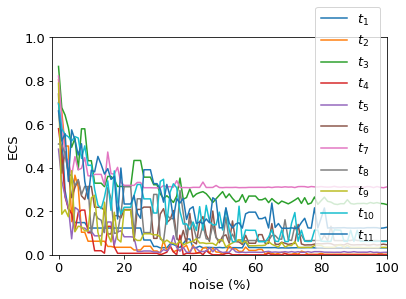

In [96]:
xs = np.arange(res+1)

for topic in sorted(sub_topics):
    ys = []
    for noise, topic_scores in pool_res:
        for topic_score in topic_scores:
            if topic_score[0] == topic:
                score = topic_scores[topic-1][1]
                ys.append(score)
    plt.plot(xs, ys, label="$t_{" + str(topic) + "}$")

#plt.rc('font', size=13)
plt.ylabel('ECS')
plt.xlabel('noise (%)')
plt.ylim(0, 1)
plt.xlim(-2, 100)
plt.legend()
#plt.savefig("simulation_with_noise.png", dpi=300)

In [51]:
over_ys_ncp = np.array(ys_ncp) + 1.96 * np.array(sd_ncp) / np.sqrt(11)
under_ys_ncp = np.array(ys_ncp) - 1.96 * np.array(sd_ncp) / np.sqrt(11)

over_ys_ncbp = np.array(ys_ncbp) + 1.96 * np.array(sd_ncbp) / np.sqrt(11)
under_ys_ncbp = np.array(ys_ncbp) - 1.96 * np.array(sd_ncbp) / np.sqrt(11)

over_ys_necs = np.array(ys_necs) + 1.96 * np.array(sd_necs) / np.sqrt(11)
under_ys_necs = np.array(ys_necs) - 1.96 * np.array(sd_necs) / np.sqrt(11)

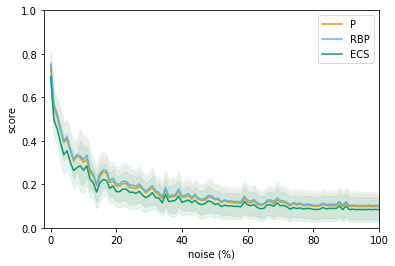

In [53]:
xs = np.arange(res+1)

plt.fill_between(xs, over_ys_ncp, under_ys_ncp, color='#E69F00', alpha=.1)
plt.fill_between(xs, over_ys_ncbp, under_ys_ncbp, color='#56B4E9', alpha=.1)
plt.fill_between(xs, over_ys_necs, under_ys_necs, color='#009E73', alpha=.1)

plt.plot(xs, ys_ncp, color='#E69F00', label='P')
plt.plot(xs, ys_ncbp, color='#56B4E9', label='RBP')
plt.plot(xs, ys_necs, color='#009E73', label='ECS')

#plt.rc('font', size=13)
plt.ylabel('score')
plt.xlabel('noise (%)')
plt.ylim(0, 1)
plt.xlim(-2, 100)
plt.legend()
#plt.savefig("simulation_with_noise_mean.png", dpi=300)

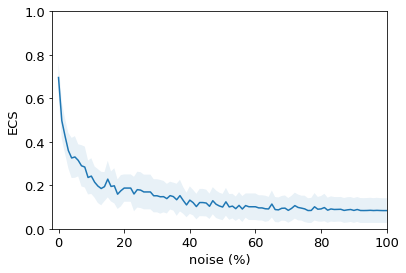

In [110]:
xs = np.arange(res+1)

plt.plot(xs, ys_ncp, color='#E69F00', label='P')
plt.fill_between(xs, over_ys_ncp, under_ys_ncp, color='#E69F00', alpha=.1)

plt.plot(xs, ys_ncbp, color='#56B4E9', label='RBP')
plt.fill_between(xs, over_ys_ncbp, under_ys_ncbp, color='#56B4E9', alpha=.1)

plt.plot(xs, ys_necs, color='#009E73', label='ECS')
plt.fill_between(xs, over_ys_necs, under_ys_necs, color='#009E73', alpha=.1)

#plt.rc('font', size=13)
plt.ylabel('score')
plt.xlabel('noise (%)')
plt.ylim(0, 1)
plt.xlim(-2, 100)
#plt.legend()
plt.savefig("simulation_with_noise_mean.png", dpi=300)

# Tables

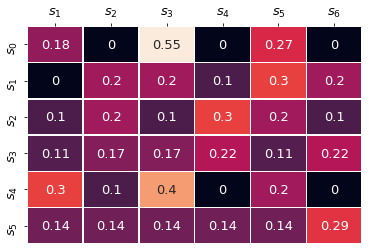

In [83]:
topic = 1

transitions_table = get_transitions_table(len(sub_topics[topic]), 
                                              min(sub_topics[topic]), 
                                              all_sequences[topic])

a = to_matrix(transitions_table)
plt.rc('font', size=13)
labels = np.copy(a)
labels = np.round_(labels, 2)
labels = labels.astype(str)
labels[a < 0.01] = "$\\varepsilon$"
labels[a == 0.0] = "0"
y_axis_labels = ["$s_0$", "$s_1$", "$s_2$", "$s_3$", "$s_4$", "$s_5$"]
x_axis_labels = ["$s_1$", "$s_2$", "$s_3$", "$s_4$", "$s_5$", "$s_6$"]
ax = sns.heatmap(a, xticklabels=x_axis_labels, yticklabels=y_axis_labels, vmin=0, vmax=0.5, annot=labels, linewidths=.5, fmt = '', cbar = False)
ax.xaxis.set_ticks_position('top')
plt.savefig("heat_map.png", dpi=300)

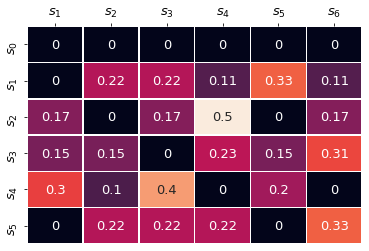

In [85]:
rel_table, irr_table, p_rel, _ = get_transitions_tables(num_subtopics, 
                                                        min(sub_topics[topic]), 
                                                        all_sequences[topic])

a = to_matrix(rel_table)
plt.rc('font', size=13)
labels = np.copy(a)
labels = np.round_(labels, 2)
labels = labels.astype(str)
labels[a < 0.01] = "$\\varepsilon$"
labels[a == 0.0] = "0"
y_axis_labels = ["$s_0$", "$s_1$", "$s_2$", "$s_3$", "$s_4$", "$s_5$"]
x_axis_labels = ["$s_1$", "$s_2$", "$s_3$", "$s_4$", "$s_5$", "$s_6$"]
ax = sns.heatmap(a, xticklabels=x_axis_labels, yticklabels=y_axis_labels, vmin=0, vmax=0.5, annot=labels, linewidths=.5, fmt = '', cbar = False)
ax.xaxis.set_ticks_position('top')
plt.savefig("heat_map_rel.png", dpi=300)

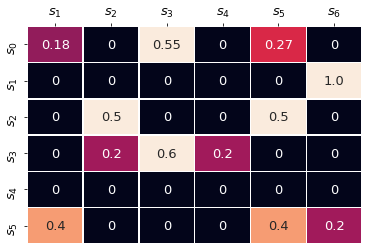

In [86]:
a = to_matrix(irr_table)
plt.rc('font', size=13)
labels = np.copy(a)
labels = np.round_(labels, 2)
labels = labels.astype(str)
labels[a < 0.01] = "$\\varepsilon$"
labels[a == 0.0] = "0"
y_axis_labels = ["$s_0$", "$s_1$", "$s_2$", "$s_3$", "$s_4$", "$s_5$"]
x_axis_labels = ["$s_1$", "$s_2$", "$s_3$", "$s_4$", "$s_5$", "$s_6$"]
ax = sns.heatmap(a, xticklabels=x_axis_labels, yticklabels=y_axis_labels, vmin=0, vmax=0.5, annot=labels, linewidths=.5, fmt = '', cbar = False)
ax.xaxis.set_ticks_position('top')
plt.savefig("heat_map_irr.png", dpi=300)